## Capital Asset Pricing Model (Linear Regression)

In [85]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

In [86]:
# Define date range: past 5 years
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# --- 1. Get GS3M (3-Month Treasury Rate) from FRED ---
gs3m = pd.DataFrame(web.DataReader("GS3M", "fred", start_date, end_date))
gs3m.reset_index(inplace=True)
gs3m.rename(columns={"DATE":"date"},inplace=True)

gs3m['date'] = pd.to_datetime(gs3m['date'])

# Set 'date' as the index
gs3m.set_index('date', inplace=True)

# Resample the DataFrame to daily frequency ('D')
gs3m_resampled = gs3m.resample('D').asfreq()

# Apply linear interpolation to fill in missing daily values
gs3m_interpolated = gs3m_resampled.interpolate(method='linear').reset_index()


In [87]:


# ---- 2. Get stocks and S&P funds data
tickers = ["^GSPC", "MSFT", "GOOG", "AAPL", "AMZN", "META", "ENB.TO"]

data = yf.download(tickers, start=start_date, end=end_date)['Close']
data.columns = ["SP500", "MSFT", "GOOG", "AAPL", "AMZN", "META", "ENB.TO"]
data.reset_index(inplace=True)
data.rename(columns={"Date":"date"},inplace=True)

# --- 3. Merge all data into a single DataFrame ---
combined = data.merge(gs3m_interpolated, on="date")

# --- 4. Drop rows with missing values (optional) ---
combined.dropna(inplace=True)
combined['date']=pd.to_datetime(combined['date'])

# --- 5. Show result ---
print(combined.head())

[*********************100%***********************]  7 of 7 completed

        date      SP500        MSFT       GOOG       AAPL        AMZN  \
0 2020-05-01  70.151207  114.302002  29.808615  65.719223  201.321182   
1 2020-05-04  71.143784  115.799500  30.198875  66.027260  204.297134   
2 2020-05-05  72.211586  115.889999  30.553656  67.237030  206.098663   
3 2020-05-06  72.956589  117.563004  30.702665  67.047440  207.492096   
4 2020-05-07  73.711319  118.380501  31.660563  68.304482  210.268997   

         META       ENB.TO      GS3M  
0  167.094696  2830.709961  0.130000  
1  171.181870  2842.739990  0.132903  
2  173.019638  2868.439941  0.133871  
3  174.723419  2848.419922  0.134839  
4  175.738022  2881.189941  0.135806  


### Data Visualization

We first start exploring the data plot some stocks values over time to visualize their trends.
For example, Amazon stocks close value has larger increase and decrease over time when compare to SP500. This makes sense, given that SP500 is a diverse fund that decrease risks (and also the expected return). 

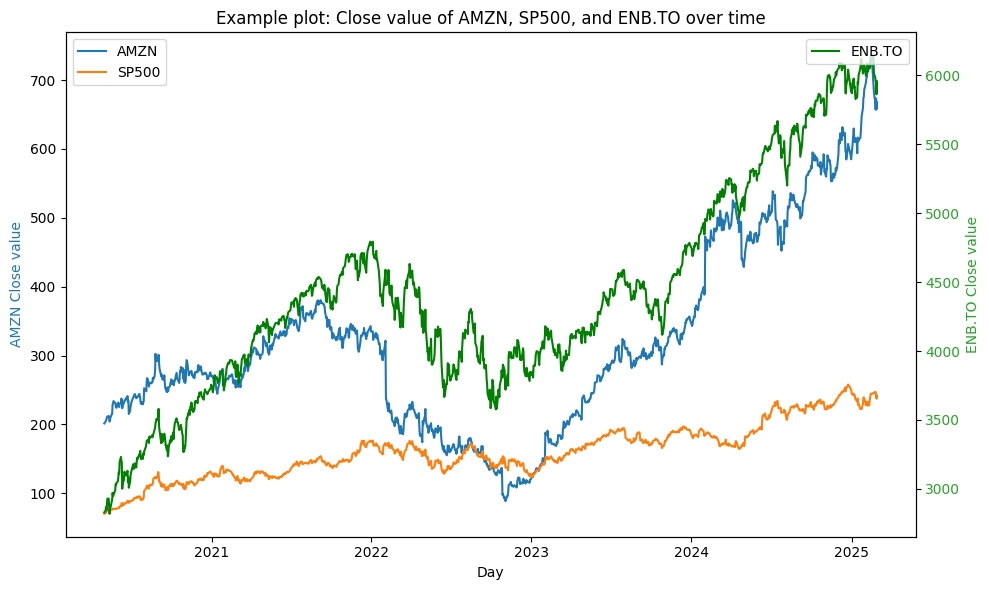

In [122]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(combined['date'],combined['AMZN'], label= "AMZN")
ax1.set_xlabel("Day")
ax1.set_ylabel("AMZN Close value", color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(combined['date'],combined['ENB.TO'], label = "ENB.TO", color = "green")

ax1.plot(combined['date'],combined['SP500'], label = "SP500")
ax2.set_ylabel("ENB.TO Close value", color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Add a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Title of the plot
plt.title("Example plot: Close value of AMZN, SP500, and ENB.TO over time")

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

The next graph shows Amazon close value and Enrbidge close value versus S&P500 close value. We can see that they have similar pattern to random walkers; suggestive to more complex and fun modelling using random walkers! 

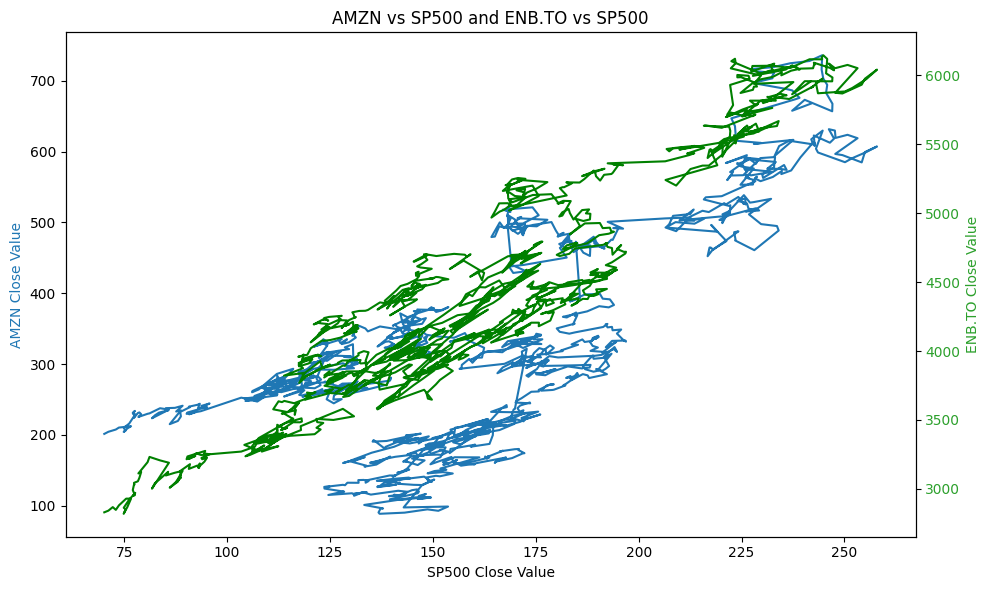

In [ ]:

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(combined['SP500'],combined['AMZN'])
ax1.set_xlabel("SP500 Close Value")
ax1.set_ylabel("AMZN Close Value", color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(combined['SP500'],combined['ENB.TO'], color = "green")
ax2.set_ylabel("ENB.TO Close Value", color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Add title
plt.title("AMZN vs SP500 and ENB.TO vs SP500")

plt.tight_layout()
plt.show()

Now, as a proxy for risk-free rate, we used the 3-month treasury rate from USA (data fetched from FRED). The data is given monthly, and we apply a linear interpolation to obtain daily data. Below is the plot:

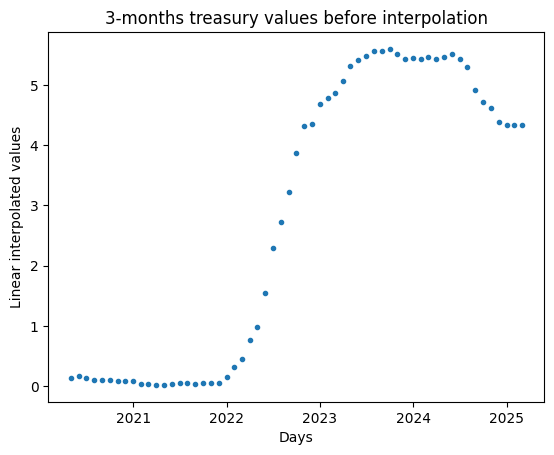

In [128]:
plt.plot(gs3m.index, gs3m["GS3M"],'.')
plt.xlabel("Days")
plt.ylabel("Linear interpolated values")
plt.title("3-months treasury values before interpolation");

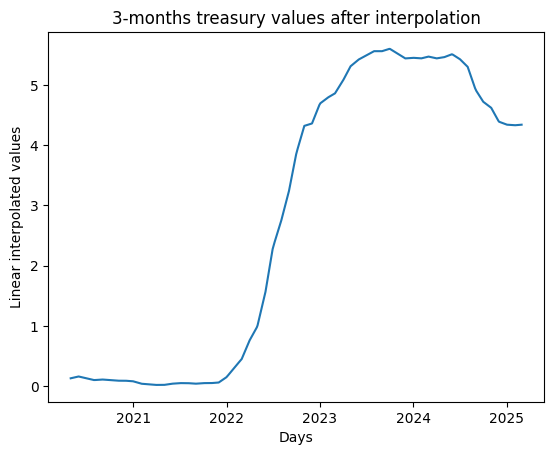

In [129]:
plt.plot(combined["date"], combined["GS3M"])
plt.xlabel("Days")
plt.ylabel("Linear interpolated values")
plt.title("3-months treasury values after interpolation");

Once we visualize the data, we follow-up with the Capital Asset Pricing Model where they model the expected return of a stock j as a function of the expected return of risk-free assets, and on the return of the market portfolio. Then, we have: 

$$ R_j = R_{riskfree} + \beta_j \left(R_{market}-R_{riskfree}\right) + \alpha_j + \epsilon 
$$,

where $\epsilon$ is some noise (gaussian). Rearranging the equation, we have:

$$ \begin{aligned} 
& R_{j} - R_{riskfree} = \beta_j \left(R_{market}-R_{riskfree}\right) + \alpha_j + \epsilon \\
& \Delta R_j = \alpha_j + \beta_j \Delta R_{market} + \epsilon \\
\end{aligned}
$$


The next step is then fit these modle to the data. In this case, we will fit the AMZN, ENB.TO stocks using SP500 as a proxy for the market, and GS3M as a proxy for return of risk-free asset rate.

*Note: need to check the transformations below*

In [130]:
## calculating continuous compounding return 
compounded_return = np.log(1 +  (combined['GS3M'].iloc[1:].values*0.01)/(np.diff(combined['date']).astype('timedelta64[D]').astype(float)/360))
data_log = combined[["SP500", "MSFT", "GOOG", "AAPL", "AMZN", "META", "ENB.TO"]].apply(np.log)
data_trans= data_log.diff().dropna()

In [131]:
result_df = data_trans.iloc[0:].values - compounded_return[:, None]

# Convert the result back into a DataFrame (if needed)
result_df = pd.DataFrame(result_df, columns=data_trans.columns, index=combined['date'].iloc[1:])


### Linear Regression using PyMC (bayesian inference)

#### 1. Amazon stocks

In [132]:
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

X = np.array(result_df["SP500"])
Y = np.array(result_df["AMZN"])

X_with_intercept = np.column_stack([np.ones(len(X)), X])

# Set up the PyMC3 model
with pm.Model() as model:
    # Priors for the intercept and slope
    alpha = pm.Normal('alpha', mu=0, sigma=10)  # Intercept (alpha)
    beta = pm.Normal('beta', mu=0, sigma=10)   # Slope  (beta_amazon)
    
    # Likelihood (the model for Y)
    sigma = pm.HalfNormal('sigma', sigma=1)  # Standard deviation of the errors
    mu = alpha + beta * X  # The linear model
    
    # Data likelihood (assuming normal errors)
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
    
    # Sample from the posterior
    trace = pm.sample(1000, return_inferencedata=True)
    
    posterior_predictive = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [Y_obs]


In [133]:
# Trace summary: Posterior distribution of parameters
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.002,0.001,-0.004,0.000,0.0,0.0,1745.0,2003.0,1.0
beta,0.999,0.001,0.998,1.000,0.0,0.0,1930.0,2129.0,1.0
sigma,0.025,0.001,0.024,0.026,0.0,0.0,2277.0,2624.0,1.0


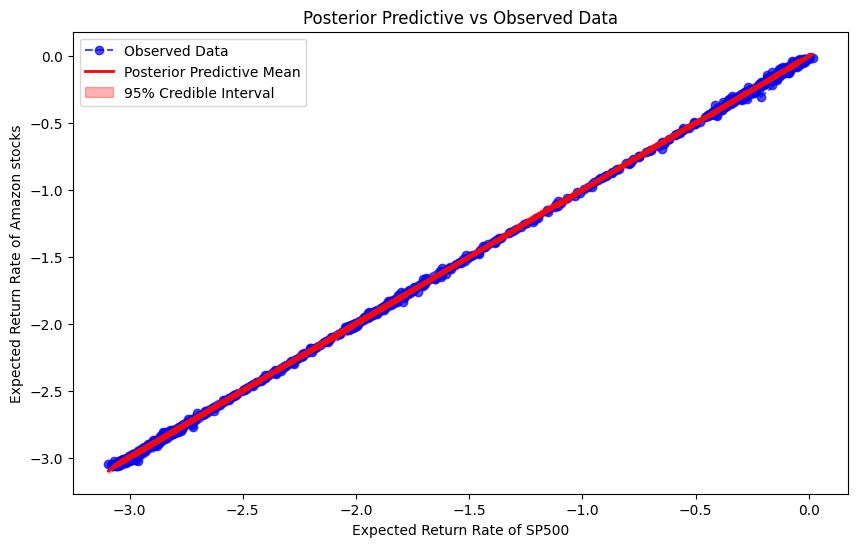

In [145]:
# Extract the posterior predictive samples for 'obs'
posterior_samples = trace.posterior_predictive.Y_obs

# Calculate the 95% credible interval
lower_bound = np.percentile(posterior_samples, 2.5, axis=0)
upper_bound = np.percentile(posterior_samples, 97.5, axis=0)
mean_posterior = np.mean(posterior_samples,axis=0)
# Plot the observed data and posterior predictions
plt.figure(figsize=(10, 6))

# Plot the observed data
plt.plot(X, Y, label='Observed Data', color='blue', marker='o', linestyle='--', alpha=0.7)

# Plot the posterior predictive mean
plt.plot(X, mean_posterior[0,:], label='Posterior Predictive Mean', color='red', linestyle='-', linewidth=2)

# Plot the 95% credible interval
plt.fill_between(X, lower_bound[0,:], upper_bound[0,:], color='red', alpha=0.3, label='95% Credible Interval')

# Add labels and legend
plt.xlabel('Expected Return Rate of SP500')
plt.ylabel('Expected Return Rate of Amazon stocks')
plt.title('Posterior Predictive vs Observed Data')
plt.legend()

plt.show()

#### 2. Microsoft

In [135]:
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

X = np.array(result_df["SP500"])
Y = np.array(result_df["MSFT"])

X_with_intercept = np.column_stack([np.ones(len(X)), X])

# Set up the PyMC3 model
with pm.Model() as model:
    # Priors for the intercept and slope
    alpha = pm.Normal('alpha', mu=0, sigma=10)  # Intercept (alpha)
    beta = pm.Normal('beta', mu=0, sigma=10)   # Slope  (beta_amazon)
    
    # Likelihood (the model for Y)
    sigma = pm.HalfNormal('sigma', sigma=1)  # Standard deviation of the errors
    mu = alpha + beta * X  # The linear model
    
    # Data likelihood (assuming normal errors)
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
    
    # Sample from the posterior
    trace = pm.sample(1000, return_inferencedata=True)
    
    posterior_predictive = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Sampling: [Y_obs]


In [136]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.001,0.001,-0.003,0.00,0.0,0.0,2512.0,2515.0,1.0
beta,0.999,0.000,0.999,1.00,0.0,0.0,2419.0,2361.0,1.0
sigma,0.019,0.000,0.018,0.02,0.0,0.0,2762.0,2699.0,1.0


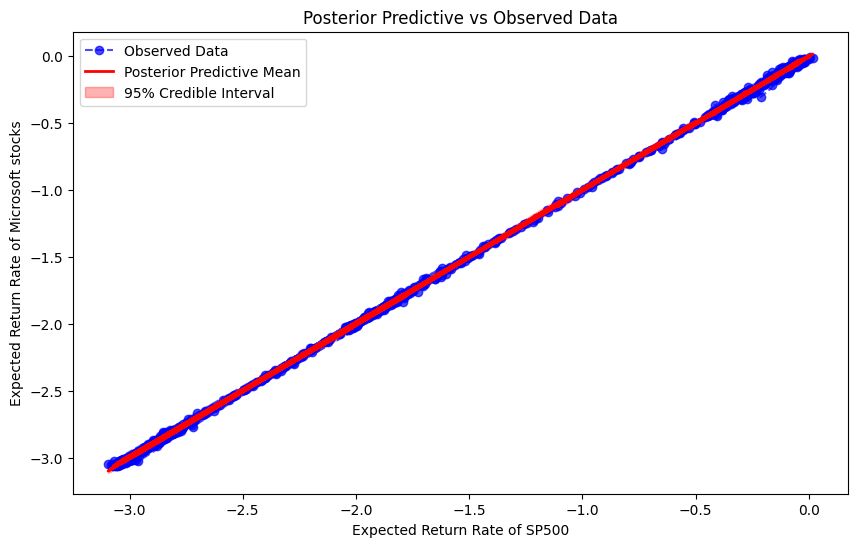

In [144]:
# Extract the posterior predictive samples for 'obs'
posterior_samples = trace.posterior_predictive.Y_obs

# Calculate the 95% credible interval
lower_bound = np.percentile(posterior_samples, 2.5, axis=0)
upper_bound = np.percentile(posterior_samples, 97.5, axis=0)
mean_posterior = np.mean(posterior_samples,axis=0)
# Plot the observed data and posterior predictions
plt.figure(figsize=(10, 6))

# Plot the observed data
plt.plot(X, Y, label='Observed Data', color='blue', marker='o', linestyle='--', alpha=0.7)

# Plot the posterior predictive mean
plt.plot(X, mean_posterior[0,:], label='Posterior Predictive Mean', color='red', linestyle='-', linewidth=2)

# Plot the 95% credible interval
plt.fill_between(X, lower_bound[0,:], upper_bound[0,:], color='red', alpha=0.3, label='95% Credible Interval')

# Add labels and legend
plt.xlabel('Expected Return Rate of SP500')
plt.ylabel('Expected Return Rate of Microsoft stocks')
plt.title('Posterior Predictive vs Observed Data')
plt.legend()

plt.show()

#### 3. Enbridge

In [138]:
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

X = np.array(result_df["SP500"])
Y = np.array(result_df["ENB.TO"])

X_with_intercept = np.column_stack([np.ones(len(X)), X])

# Set up the PyMC3 model
with pm.Model() as model:
    # Priors for the intercept and slope
    alpha = pm.Normal('alpha', mu=0, sigma=10)  # Intercept (alpha)
    beta = pm.Normal('beta', mu=0, sigma=10)   # Slope  (beta_amazon)
    
    # Likelihood (the model for Y)
    sigma = pm.HalfNormal('sigma', sigma=1)  # Standard deviation of the errors
    mu = alpha + beta * X  # The linear model
    
    # Data likelihood (assuming normal errors)
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
    
    # Sample from the posterior
    trace = pm.sample(1000, return_inferencedata=True)
    
    posterior_predictive = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Sampling: [Y_obs]


In [139]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.001,0.001,-0.002,0.000,0.0,0.0,2334.0,2324.0,1.0
beta,1.000,0.000,0.999,1.000,0.0,0.0,2271.0,2449.0,1.0
sigma,0.013,0.000,0.012,0.013,0.0,0.0,2391.0,2188.0,1.0


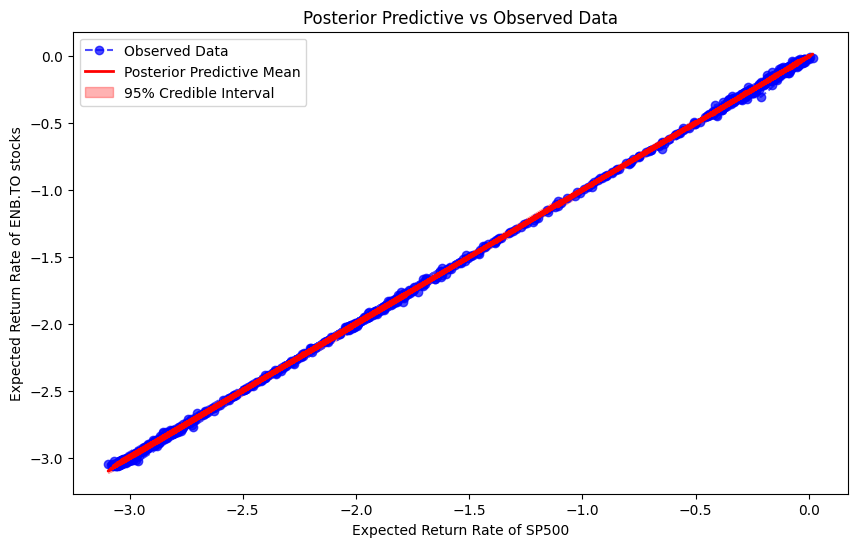

In [143]:
# Extract the posterior predictive samples for 'obs'
posterior_samples = trace.posterior_predictive.Y_obs

# Calculate the 95% credible interval
lower_bound = np.percentile(posterior_samples, 2.5, axis=0)
upper_bound = np.percentile(posterior_samples, 97.5, axis=0)
mean_posterior = np.mean(posterior_samples,axis=0)
# Plot the observed data and posterior predictions
plt.figure(figsize=(10, 6))

# Plot the observed data
plt.plot(X, Y, label='Observed Data', color='blue', marker='o', linestyle='--', alpha=0.7)

# Plot the posterior predictive mean
plt.plot(X, mean_posterior[0,:], label='Posterior Predictive Mean', color='red', linestyle='-', linewidth=2)

# Plot the 95% credible interval
plt.fill_between(X, lower_bound[0,:], upper_bound[0,:], color='red', alpha=0.3, label='95% Credible Interval')

# Add labels and legend
plt.xlabel('Expected Return Rate of SP500')
plt.ylabel('Expected Return Rate of ENB.TO stocks')
plt.title('Posterior Predictive vs Observed Data')
plt.legend()

plt.show()